In [1]:
import tensorflow as tf
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
@tf.function()
def loadtrainimage(image):
    image=tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [300,300],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image,size=(256,256,3))
    image = (image/127.5)-1
    return image
print(loadtrainimage("/kaggle/input/facades-dataset/trainA/100_A.jpg"))

tf.Tensor(
[[[ 0.3803922   0.38823533  0.3411765 ]
  [ 0.24705887  0.254902    0.19215691]
  [ 0.07450986  0.082353    0.0196079 ]
  ...
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]]

 [[ 0.32549024  0.33333337  0.2941177 ]
  [ 0.35686278  0.36470592  0.30196083]
  [ 0.20000005  0.20000005  0.12156868]
  ...
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]]

 [[ 0.36470592  0.37254906  0.33333337]
  [ 0.45882356  0.45882356  0.39607847]
  [ 0.20784318  0.18431377  0.11372554]
  ...
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]]

 ...

 [[ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]
  [ 0.0196079   0.0196079   0.0196079 ]
  ...
  [ 0.58431387 -0.0666666  -0.00392151]
  [ 0.53725505 -0.0666666  -0.00392151]
  [ 0.45882356 -0.03529406  0.027

In [3]:
@tf.function()
def loadtestimage(image):
    image=tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    mage = tf.image.resize(image, [256,256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image,size=(256,256,3))
    image = (image/127.5)-1
    return image
print(loadtestimage("/kaggle/input/facades-dataset/trainB/100_B.jpg"))

tf.Tensor(
[[[-0.9764706  -0.9764706   0.5294119 ]
  [-0.99215686 -0.9764706   0.5686276 ]
  [-0.99215686 -1.          0.68627465]
  ...
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]]

 [[-0.9764706  -0.9764706   0.5294119 ]
  [-0.99215686 -0.9764706   0.5686276 ]
  [-0.99215686 -1.          0.68627465]
  ...
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]]

 [[-0.9764706  -0.9764706   0.5294119 ]
  [-0.99215686 -0.9764706   0.5686276 ]
  [-0.99215686 -1.          0.68627465]
  ...
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]]

 ...

 [[-0.9764706  -0.9764706   0.5294119 ]
  [-0.99215686 -0.9764706   0.5686276 ]
  [-0.99215686 -1.          0.68627465]
  ...
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.7411766 ]
  [-1.         -1.          0.741

In [4]:
def downsample(filters,size,batchnorm=True):
    initializer=tf.random_normal_initializer(0.,0.02)
    downsample = tf.keras.Sequential()
    downsample.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    if batchnorm:
        downsample.add(tf.keras.layers.BatchNormalization())
    downsample.add(tf.keras.layers.LeakyReLU())
    return downsample

In [5]:
def upsample(filters,size,dropout=True):
    initializer=tf.random_normal_initializer(0.,0.02)
    upsample = tf.keras.Sequential()
    upsample.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))
    if dropout:
        upsample.add(tf.keras.layers.BatchNormalization())
    upsample.add(tf.keras.layers.Dropout(0.5))
    return upsample

In [6]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, batchnorm=False),
    downsample(128, 4), 
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
  ]

    up_stack = [
    upsample(512, 4, dropout=True),  
    upsample(512, 4, dropout=True),  
    upsample(512, 4, dropout=True),  
    upsample(512, 4), 
    upsample(256, 4), 
    upsample(128, 4),  
    upsample(64, 4),  
  ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [7]:
generator = Generator()

In [8]:
def generator_loss(disc_generated_output,gen_output,target):
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    LAMBDA = 100
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) 

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [11]:
discriminator = Discriminator()

In [12]:
def discriminator_loss(disc_real_output, disc_generated_output):
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [13]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [14]:
train_dataset = tf.data.Dataset.list_files(str( '/kaggle/input/facades-dataset/trainB/*.jpg'))
train_dataset = train_dataset.map(loadtrainimage,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(400)
train_dataset = train_dataset.batch(1)
print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [15]:
test_dataset = tf.data.Dataset.list_files(str( '/kaggle/input/facades-dataset/trainA/*.jpg'))
test_dataset = test_dataset.map(loadtestimage,)
test_dataset = test_dataset.shuffle(400)
test_dataset = test_dataset.batch(1)
print(test_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [16]:
checkpoint_dir = '/kaggle/working/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
def fit(train_ds, test_ds, steps):
    step=0
    for input_image, target in zip(train_ds.repeat().take(steps),test_ds.repeat().take(steps)):
        train_step(input_image, target)
        step+=1
        if (step + 1) % 5000 == 0:
            print(step)
            checkpoint.save(file_prefix=checkpoint_prefix)

In [18]:
fit(train_dataset, test_dataset, steps=40000)

2024-01-24 14:32:46.799400: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_8/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4999
9999
14999
19999
24999
29999
34999
39999


In [19]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [20]:
from matplotlib import pyplot as plt
from IPython import display
def generate_images(model, test_input,):
#     test_input = tf.expand_dims(test_input[0], axis=0)
#     print(test_input)
#     input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
#     input_layer=input_layer(test_input[0])
    prediction = model([test_input],training=True)
#     print(prediction)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5+0.5)
        plt.axis('off')
        plt.show()

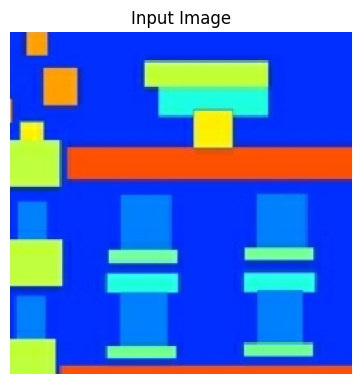

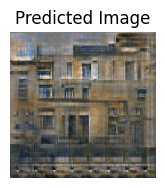

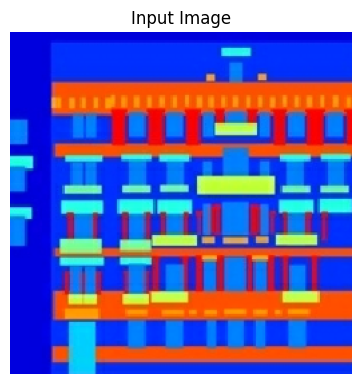

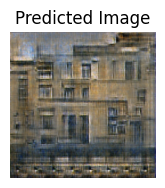

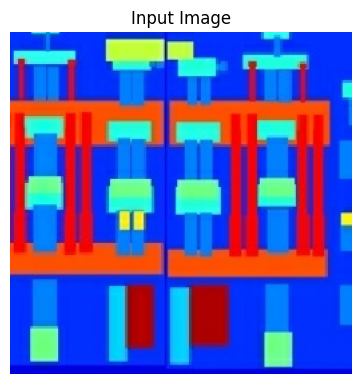

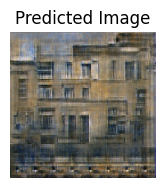

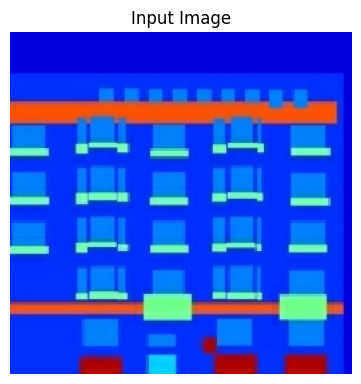

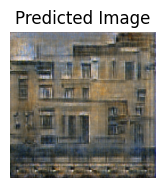

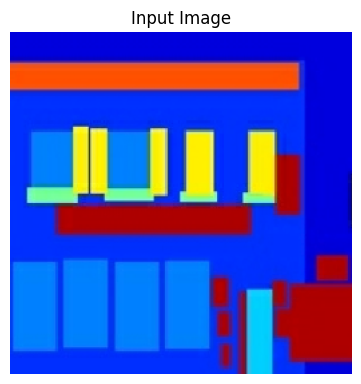

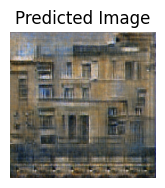

In [21]:
# Run the trained model on a few examples from the test set
for inp in train_dataset.take(5):
    generate_images(generator, inp)